In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

print(sys.executable)

/home/guevel/projects/annotix_all/DiffMS/.venv/bin/python


In [20]:
import torch
from diffms import ROOT

model_path = ROOT / "models" / "checkpoints"
diffms_dict = torch.load(model_path / "diffms_msg.ckpt")

In [9]:
{t: len([k for k in diffms_dict["state_dict"].keys() if t in k]) for t in ["decoder", "encoder"]}

{'decoder': 304, 'encoder': 59}

In [12]:
decoder_dict = torch.load(model_path / "decoder.ckpt")
len(decoder_dict["state_dict"].keys())

305

In [17]:
encoder_dict = torch.load(model_path / "encoder_msg.pt")
len(encoder_dict)

59

In [21]:
from omegaconf import DictConfig, OmegaConf
from hydra import compose, initialize
from hydra.core.global_hydra import GlobalHydra

GlobalHydra.instance().clear()

# Initialize once at the beginning of your notebook
initialize(config_path="../configs", version_base="1.3")

# Compose the config (same as Hydra would do on CLI)
cfg: DictConfig = compose(config_name="config")

In [7]:
from diffms import ROOT
from diffms.mist.data import splitter, datasets

data_splitter = splitter.PresetSpectraSplitter(
    split_file = ROOT / cfg.dataset.split_file
)

spectra_mol_pairs = datasets.get_paired_spectra(**cfg.dataset)
spectra_mol_pairs = list(zip(*spectra_mol_pairs))

231104it [00:01, 151456.63it/s]
231104it [00:47, 4894.16it/s]
231104it [00:00, 3496587.29it/s]


In [8]:
split_file, (train, val, test) = data_splitter.get_splits(spectra_mol_pairs)

In [ ]:
spectra = train[0][0]
# Brut formula
print(spectra.get_spectra_formula())

# List of intensity and m/Z peaks ?
spectra.get_spec()

# 
spectra.spectrum_nam

C11H19NO9


('ms2peaks',)

In [22]:
import logging

from rdkit import RDLogger

from diffms.analysis.visualization import MolecularVisualization
from diffms.datasets import spec2mol_dataset
from diffms.diffusion.extra_features import DummyExtraFeatures, ExtraFeatures
from diffms.metrics.molecular_metrics_discrete import TrainMolecularMetricsDiscrete
from diffms.diffusion.extra_features_molecular import ExtraMolecularFeatures


# Temporarily silence all but WARNING level
RDLogger.DisableLog('rdApp.warning')

dataset_config = cfg["dataset"]

if dataset_config["name"] not in ("canopus", "msg"):
    raise NotImplementedError("Unknown dataset {}".format(cfg["dataset"]))

print('Creating datamodule')
datamodule = spec2mol_dataset.Spec2MolDataModule(cfg) # TODO: Add hyper for n_bits

print('Getting dataste infos')
dataset_infos = spec2mol_dataset.Spec2MolDatasetInfos(datamodule, cfg)

print('Making domain features')
domain_features = ExtraMolecularFeatures(dataset_infos=dataset_infos)

print('Making extra features')
if cfg.model.extra_features is not None:
    extra_features = ExtraFeatures(cfg.model.extra_features, dataset_info=dataset_infos)
else:
    extra_features = DummyExtraFeatures()

print('Compute input/output dims')
dataset_infos.compute_input_output_dims(datamodule=datamodule, extra_features=extra_features, domain_features=domain_features)

logging.info("Dataset infos:", dataset_infos.output_dims)

print('Training metrics.')
train_metrics = TrainMolecularMetricsDiscrete(dataset_infos)

# We do not evaluate novelty during training
print('Get viz tools.')
visualization_tools = MolecularVisualization(cfg.dataset.remove_h, dataset_infos=dataset_infos)

model_kwargs = {
    'dataset_infos': dataset_infos,
    'train_metrics': train_metrics,
    'visualization_tools': visualization_tools,
    'extra_features': extra_features, 
    'domain_features': domain_features,
}

Creating datamodule


231104it [00:01, 138784.09it/s]
231104it [00:46, 5004.94it/s]
231104it [00:00, 3615990.27it/s]


Getting dataste infos
Making domain features
Making extra features
Compute input/output dims
Training metrics.
Get viz tools.


In [31]:
import os
from diffms import ROOT
from diffms.diffusion_model_spec2mol import Spec2MolDenoisingDiffusion
from diffms.spec2mol_main import load_weights

model = Spec2MolDenoisingDiffusion(cfg=cfg, **model_kwargs)

weight_path = ROOT / cfg.general.encoder
if not os.path.isfile:
    raise ValueError(f"The path indicated does not exist {weight_path}")

logging.info(f"Loading weights from {weight_path}")
model = load_weights(model, weight_path)

In [12]:
import torch

# Setup the device
device = torch.device("cuda:2")

dataloader = datamodule.test_dataloader()

for b in dataloader:
    b = {
        k: v.to(device) if isinstance(v, torch.Tensor) else v
        for k, v in b.items()
    }
    break

In [33]:
b["graph"]

DataBatch(x=[4900, 8], edge_index=[2, 10654], edge_attr=[10654, 5], y=[128, 2048], inchi=[128], batch=[4900], ptr=[129])

In [13]:
model.to(device)

with torch.no_grad():
    output, aux = model.encoder(b)

In [14]:
merge = getattr(cfg.dataset, 'merge', 'none')

data = b["graph"]
if model.merge == 'mist_fp':
    data.y = aux["int_preds"][-1]
if model.merge == 'merge-encoder_output-linear':
    encoder_output = aux['h0']
    data.y = model.merge_function(encoder_output)
elif model.merge == 'merge-encoder_output-mlp':
    encoder_output = aux['h0']
    data.y = model.merge_function(encoder_output)
elif model.merge == 'downproject_4096':
    data.y = model.merge_function(output)

In [16]:
def move_data_to_device(data, device):
    for attr in vars(data)["_store"]:
        if isinstance(x := getattr(data, attr), torch.Tensor):
            setattr(data, attr, x.to(device))
    
    return data

In [ ]:
from rdkit import Chem

data = move_data_to_device(data, device)

true_mols = [Chem.inchi.MolFromInchi(data.get_example(idx).inchi) for idx in range(len(data))] # Is this correct?
predicted_mols = [list() for _ in range(len(data))]

for idx, mol in enumerate(model.sample_batch(data)):
    predicted_mols[idx].append(mol)

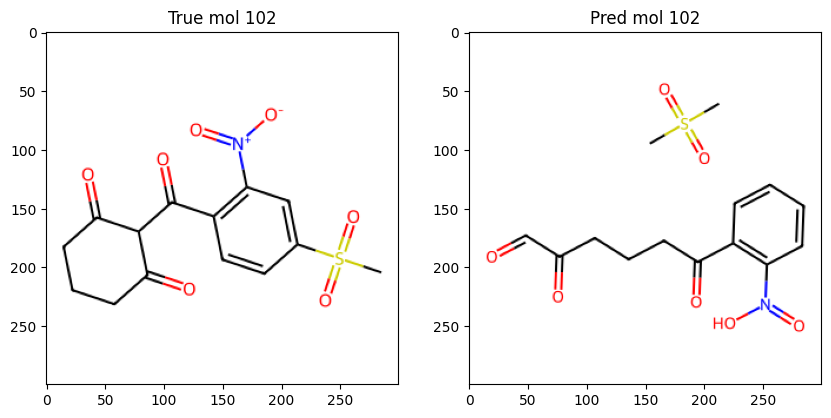

In [ ]:
import random

import matplotlib.pyplot as plt
from rdkit.Chem import Draw

idx = random.choice(range(len(data)))

tm = true_mols[idx]
pm = predicted_mols[idx][0]

tm_img = Draw.MolToImage(tm)
pm_img = Draw.MolToImage(pm)

fig, ax = plt.subplots(1, 2, figsize=(10, 20))

ax[0].imshow(tm_img)
ax[0].set_title(f"True mol {idx}")

ax[1].imshow(pm_img)
ax[1].set_title(f"Pred mol {idx}")

plt.show()
